# Machine learning and graph embeddings

<div style="display: flex; align-items: center;">
    <a target="_blank" href="https://colab.research.google.com/github/yy/netsci-course/blob/master/docs/m11-ml/lab11.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" style="vertical-align: -8px; margin-right: 10px;" />
        Open this notebook in Google Colab
    </a>
</div>


<div style="display: flex; align-items: center;">
    <a href="https://raw.githubusercontent.com/yy/netsci-course/master/docs/m11-ml/lab11.ipynb" download>
        <img src="http://yyahn.com/netsci-course/images/download_icon.png" style="vertical-align: -8px; margin-right: 10px;" />
        Download this notebook (File -> Save As)
    </a>
</div>

## A simple illustration

Let's first conceptually think about the two main graph machine learning tasks: node classification and link prediction. 

First, let me create a very simple, stylized network. The network has two distinct community structure, which is completely correlated with the colors (the classes) of the nodes (red or lightblue). Most edges are within the same community. 

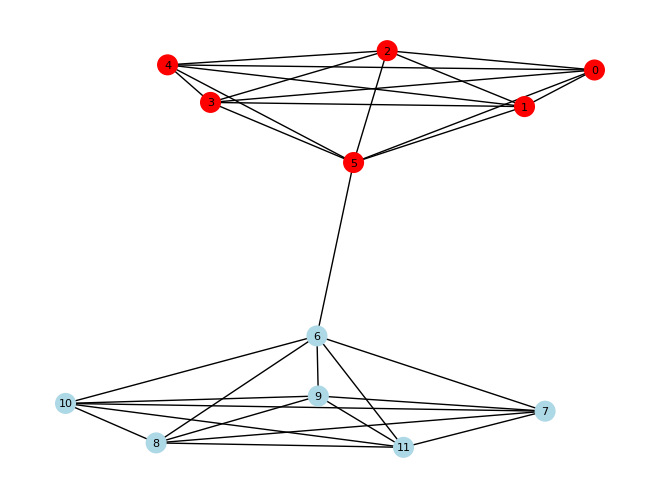

In [1]:
import networkx as nx

G = nx.barbell_graph(6, 0)

for i in range(6):
    G.nodes[i]['color'] = 'red'
for i in range(6, 12):
    G.nodes[i]['color'] = 'lightblue'

nx.draw(G, with_labels=True, node_color=[G.nodes[i]['color'] for i in G.nodes], node_size=200, font_size=8)

### Node classification

Now, let's think about the node classification problem. Given this network, let's assume that we don't know the node class (color) of node 3 (pretend that you don't know the color of node 3!). 

What would be your strategy to predict the color of node 3? (Again, pretend that you don't know the color...)

One obvious strategy that you can think of is just to look at the immediate neighbors of node 3. If most of the neighbors are red, then maybe it's safe to guess that node 3 is also red. If most of the neighbors are lightblue, then you can guess that node 3 is lightblue. This is more or less same as the K-nearest neighbors algorithm, one of the simplest yet powerful machine learning algorithms. 

Why is this strategy viable? Which property of the real-world networks does this strategy rely on? 

Yes! This works thanks to the _homophily_, which is the tendency of nodes to connect to similar nodes. Whenever homophily exists, we also expect that the network has a community structure and a node's properties can be inferred from its neighbors! Let's try this. 

In [2]:
from collections import Counter

for node in G.nodes:
    # YOUR SOLUTION HERE
    
    print("Node id:", node)
    print(f"predicted by neighbors: {most_common_color}")
    print(f"actual color:           {G.nodes[node]['color']}")
    print()

Node id: 0
predicted by neighbors: red
actual color:           red

Node id: 1
predicted by neighbors: red
actual color:           red

Node id: 2
predicted by neighbors: red
actual color:           red

Node id: 3
predicted by neighbors: red
actual color:           red

Node id: 4
predicted by neighbors: red
actual color:           red

Node id: 5
predicted by neighbors: red
actual color:           red

Node id: 6
predicted by neighbors: lightblue
actual color:           lightblue

Node id: 7
predicted by neighbors: lightblue
actual color:           lightblue

Node id: 8
predicted by neighbors: lightblue
actual color:           lightblue

Node id: 9
predicted by neighbors: lightblue
actual color:           lightblue

Node id: 10
predicted by neighbors: lightblue
actual color:           lightblue

Node id: 11
predicted by neighbors: lightblue
actual color:           lightblue



A perfect prediction! 

As you can imagine, this strategy will become too simplistic as the network becomes more complex and noisy. But remember that what we just did is essentially the core idea of many, much fancier, machine learning algorithms including graph neural networks (GNNs). GNNs aggregate the information from the neighbors and combine with the node features to produce a new vector, which in turn can be used for more processing or prediction. 

Because of the usage of neural networks, GNNs are much more flexible than just counting the number of neighbors with a certain property. They can also utilize many features of the nodes and edges, not just the class labels. Still the idea is not that far!

### Link prediction

How about link prediction? Let's start with the same network. 

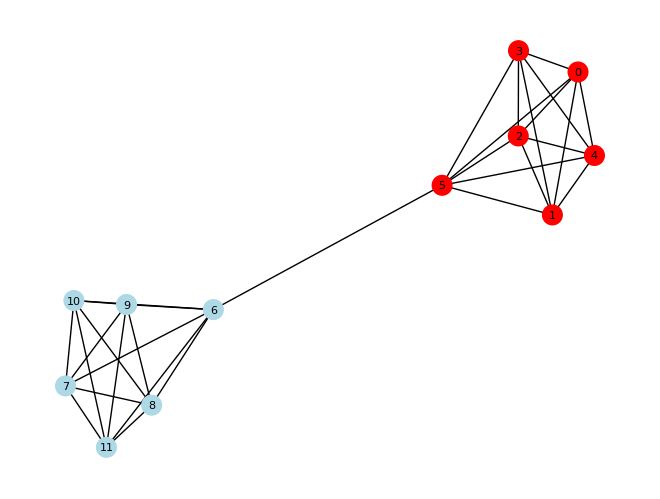

In [3]:
nx.draw(G, with_labels=True, node_color=[G.nodes[i]['color'] for i in G.nodes], node_size=200, font_size=8)

Now, mark some edges to _pretend_ that they are missing. 

In [4]:
# mark some edges to be missing. Set the edge attribute 'missing' to True
import random 

missing_edges = random.sample(list(G.edges), 5)
missing_edges

[(0, 4), (2, 4), (9, 10), (8, 11), (10, 11)]

We can also sample "negative" edges, which are not present in the network.

In [5]:
# sample negative edges
negative_edges = set()
while len(negative_edges) < 5:
    edge = tuple(random.sample(list(G.nodes), 2))
    if edge not in G.edges:
        negative_edges.add(edge)
negative_edges

{(0, 7), (8, 2), (9, 1), (10, 5), (11, 2)}

Let's draw these two see where they are located.

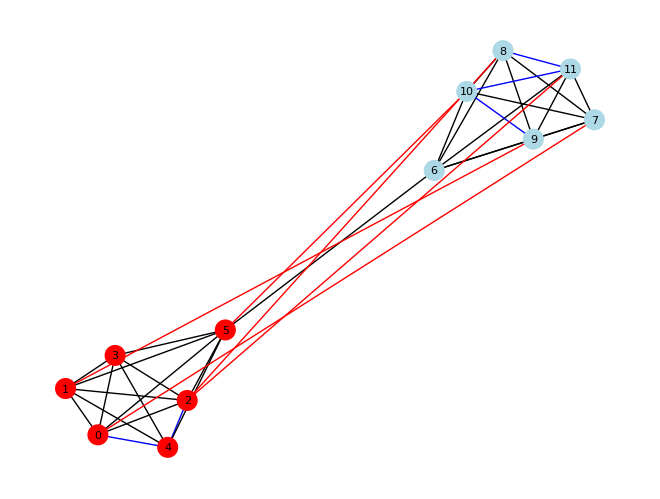

In [6]:
edge_colors = []
for edge in G.edges:
    if edge in missing_edges:
        edge_colors.append('blue')
    else:
        edge_colors.append('black')

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, pos=pos, 
        node_color=[G.nodes[i]['color'] for i in G.nodes], node_size=200, font_size=8, edge_color=edge_colors)
nx.draw_networkx_edges(G, pos=pos, edgelist=negative_edges, edge_color='red')

What do you see?

Yes! The missing edges are mostly between the nodes of the same color and the negative edges are mostly between the nodes of different colors. This is again due to the strong community structure that arises from the homophily. Because there are more edges within the same community, it's more likely that the missing edges are also within the same community; because there are fewer edges between the different communities, it's more likely that the negative edges are between the different communities.

Then, what would be simple strategies to predict the missing edges correctly, or distinguish missing edges from the negative edges?

#### Link prediction is often about defining the similarity between the nodes

One general idea is to think about the _similarity_ between the nodes. If two nodes are similar, or "close", then they are more likely to be connected. Then how should we think about the similarity?

#### Link prediction with community membership, and SBM

A super simple idea is simply use the community membership as the most informative feature of the nodes. If two nodes are in the same community, then they are "similar". If they are in different communities, then they are "dissimilar". You may think that this is too simple because we are not considering any other properties once the communities are found. But, do you remember the stochastic block models (SBM)? In the most basic SBM, the probability of connection between two nodes is determined solely by the community membership of the nodes. So, this simple idea may be not that bad!

#### Adamic-Adar index

Another simple idea is to think about similarity between nodes based on the number of common neighbors they share. If two people have many shared friends, then they are very likely to be friends. This is the idea behind the Adamic-Adar index and similar. Rather than counting the shared neighbors, Adamic-Adar index gives more weight to the shared neighbors with fewer neighbors. In doing so, the index discounts the shared neighbors that are too popular and thus less informative.  

$$ \text{Adamic-Adar}(u, v) = \sum_{w \in N(u) \cap N(v)} \frac{1}{\log |N(w)|} $$

where $N(u)$ is the set of neighbors of node $u$. Shall we try this? Let's first remove the missing edges from the network first. 

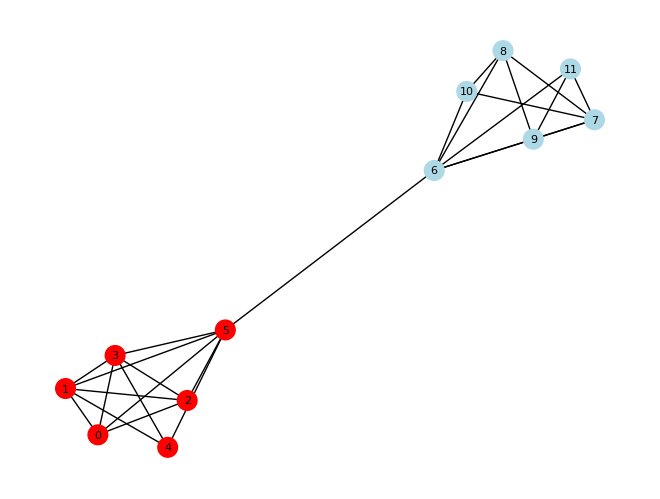

In [7]:
for edge in missing_edges:
    if G.has_edge(*edge):
        G.remove_edge(*edge)

nx.draw(G, with_labels=True, pos=pos, 
        node_color=[G.nodes[i]['color'] for i in G.nodes], node_size=200, font_size=8)

Now, for every pair of disconnected nodes, we calculate the Adamic-Adar index.

In [8]:
# calculate adamic-adar index for every pair of disconnected nodes
import numpy as np
from itertools import combinations

aa_index = {}
for u, v in combinations(G.nodes, 2):
    if G.has_edge(u, v):
        continue
    # YOUR SOLUTION HERE

    # let's only keep the non-zero ones
    if adamic_adar_index > 0:
        aa_index[(u, v)] = adamic_adar_index

sorted(aa_index.items(), key=lambda x: x[1], reverse=True)

[((8, 11), 1.6933439034806097),
 ((9, 10), 1.6933439034806097),
 ((0, 4), 1.6301195954722452),
 ((2, 4), 1.6301195954722452),
 ((10, 11), 1.072008968920998),
 ((0, 6), 0.5138983423697507),
 ((1, 6), 0.5138983423697507),
 ((2, 6), 0.5138983423697507),
 ((3, 6), 0.5138983423697507),
 ((4, 6), 0.5138983423697507),
 ((5, 7), 0.5138983423697507),
 ((5, 8), 0.5138983423697507),
 ((5, 9), 0.5138983423697507),
 ((5, 10), 0.5138983423697507),
 ((5, 11), 0.5138983423697507)]

Let's draw them on top of the network. Draw them with ligh grey color and use the thickness of the line to represent the value of the Adamic-Adar index.

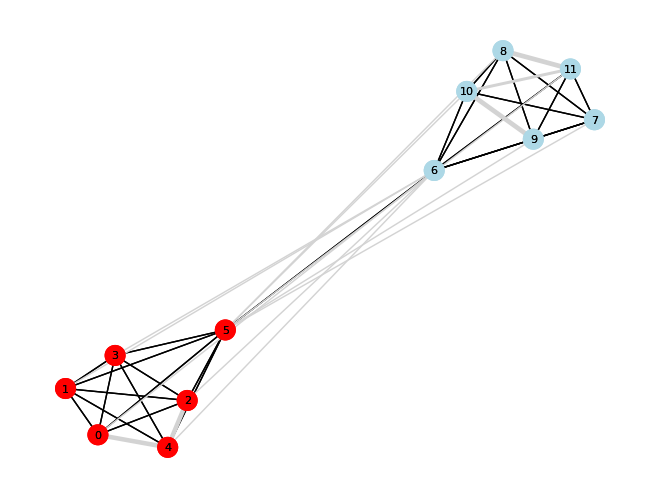

In [9]:
nx.draw(G, with_labels=True, pos=pos, 
        node_color=[G.nodes[i]['color'] for i in G.nodes], node_size=200, font_size=8)

edge_width = [aa_index[edge] * 2 for edge in aa_index]

nx.draw(G, with_labels=True, pos=pos,
        node_color=[G.nodes[i]['color'] for i in G.nodes], node_size=200, font_size=8)

# draw potential edges based on adamic-adar index
nx.draw_networkx_edges(G, pos=pos, edgelist=aa_index.keys(), width=edge_width, edge_color='lightgrey')


Cool! It seems like all the top predictions (large Adamic-Adar index) are located within the same community while those with small Adamic-Adar index are located between the different communities. We can compare this with the actual missing edges (positive) and negative edges.

In [10]:
import pandas as pd

# YOUR SOLUTION HERE

aa_index_df



,edge,adamic_adar_index,missing,negative
0,"(8, 11)",1.693344,True,False
1,"(9, 10)",1.693344,True,False
2,"(0, 4)",1.630120,True,False
3,"(2, 4)",1.630120,True,False
4,"(10, 11)",1.072009,True,False
5,"(0, 6)",0.513898,False,False
6,"(1, 6)",0.513898,False,False
7,"(2, 6)",0.513898,False,False
8,"(3, 6)",0.513898,False,False
9,"(4, 6)",0.513898,False,False


This table shows that the top 5 edges with the largest Adamic-Adar index are all positive edges, while none of the node pairs with non-zero Adamic-Adar index are negative edges. This confirms that the Adamic-Adar index is pretty good at capturing the similarity between the nodes. 

Although Adamic-Adar index is a very good heuristic, there may be numerous other measures that may work similarly. This is how the machine learning problems were tackled before the deep learning era. Many new methods were about new hand-crafted features, new similarity measures, and new ways to combine them. However, the deep learning era has changed this landscape and ushered the era of end-to-end learning that focuses on good representations. 

## Graph embeddings

Some of the most important lessons from deep learning are:

1. Good representations are crucial for good performance.
2. Usually it is hard to design good representations by hand.
3. By letting the neural network learn the representations, we can achieve better performance.

In a more classical approach, one may construct hand-crafted features and use them as input to the machine learning algorithms. For instance, in the link prediction problem, one may use the Adamic-Adar index as a feature of each pair of nodes. You can also add more features such as the number of common neighbors, the Jaccard index, the distance, etc. Each of these number captures some aspect of the similarity between the nodes and then the machine learning algorithm (e.g., logistic regression) learns how to use these features to predict the link based on examples (training data). 

However, our intuition is never perfect! We may miss some important features, or we may include some irrelevant features. By contrast, neural network methods tend to be end-to-end, meaning that they learn the representations and the prediction model simultaneously. This leads to much better representations (features) that are optimized for the task at hand. 

But, another interesting lesson has been that we can "pre-train" the neural networks using lots of data that captures the structure of the data. Once we have a good pre-trained model (and good representations), we can reuse the model for other tasks quite successfully. Word embeddings, LLMs, and graph embeddings are all examples of this idea.

### Word2vec

Word2vec is a famous example of learning embeddings. The idea is to learn the embeddings of the words simply by trying to predict words that appear in the context of the target word. This originates from the idea of "language model". 

A language model is just a statistical model (probability distribution) that capture the structure of the language. In the simplest sense, a language model is a model that can estimate the joint probability of a sequence of words.

$$ \tilde{P}_{LM}(w_1, w_2, \ldots, w_T) \approx P(w_1, w_2, \ldots, w_T) $$

This conditional probability can be factorized into the product of the conditional probabilities of each word given the previous words.

$$ P(w_1, w_2, \ldots, w_T) = P(w_1) P(w_2 | w_1) P(w_3 | w_1, w_2) \ldots P(w_T | w_1, w_2, \ldots, w_{T-1}) $$

In other words, if you can simply predict the next word (token) given the previous words, then you have a language model. Sounds familiar? This is exactly what the ChatGPT and other LLMs are doing! 

The core idea behind these complex LLMs originated from the simple idea of word2vec -- learn the vector representations (embeddings) of the words that allow us to predict the next (or previous) word. 

From the conditional probability formulation of the language model, word2vec has another simplification. Instead of thinking about many previous token, it says "let's just use a single token to predict another". In other words,

$$ P(w_t | w_{t-1}, w_{t-2}, \ldots, w_{t-n}) \approx P(w_t | w_{t-\tau}) $$

where $\tau$ is a small number (window size). This is called the "skip-gram" model because we are skipping all the words in between. Given a large corpus (a collection of sentences), word2vec keeps trying to predict the words around a focal word and use the result to update the embeddings. 




### word2vec to node2vec

The input to the word2vec model is just sentences, many of them. From this, we get the embeddings of the words. A really cool thing about this model is that the input "sentences" don't have to be real sentences. *Any* sequence of tokens can be used as the input and word2vec will happily produce the embeddings. The "tokens" that consist the input sentences can be anything -- words, characters, or even nodes in a graph!

That's the idea behind many graph embedding methods. Instead of learning the embeddings of the words, why don't we learn the embeddings of the nodes in a graph? We just need to feed many sequences of nodes to the word2vec model.

But, what should be the reasonable sequences of nodes? These sentences should be able to capture the structure of the graph. When a node follows another, they should be somehow related. How can we do that?

One super simple, yet extremely powerful idea is to use the random walks. A random walk is a sequence of nodes that starts from a node and moves to a randomly selected neighbor. By repeating this process many times, we can generate many sequences of nodes that capture the structure of the graph. Because random walks follow edges, it organically captures the structure of the graph. The more two nodes are connected (via different paths), the more likely they will appear in the same random walk. Thus they are more likely to be close in the embedding space!



Let's try this. There are many variations, but let's keep it simple and use the word2vec algorithm. We're reusing the graph with the missing edges. 

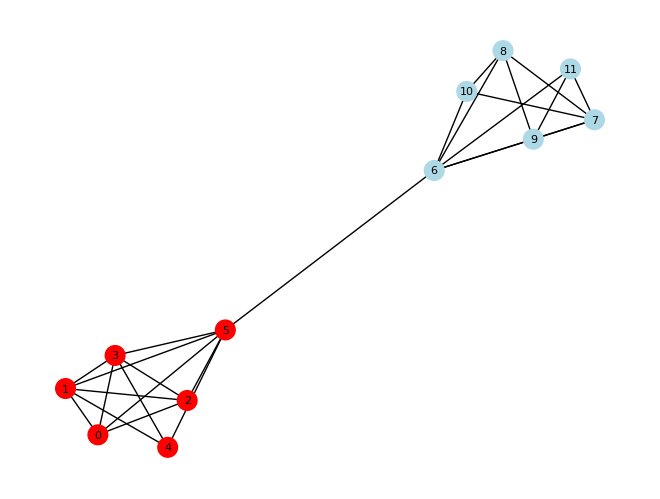

In [11]:
nx.draw(G, with_labels=True, pos=pos, 
        node_color=[G.nodes[i]['color'] for i in G.nodes], node_size=200, font_size=8)

The first step is to generate the random walks. 


In [19]:
def generate_random_walks(G, walk_length, num_walks):
    """ Generate random walks on the graph G.
    """
    for _ in range(num_walks):
        # YOUR SOLUTION HERE
        yield walk

list(generate_random_walks(G, 8, 3))

[[5, 1, 2, 0, 1, 0, 3, 0, 2],
 [1, 2, 5, 1, 0, 5, 1, 4, 3],
 [3, 4, 5, 0, 2, 0, 1, 2, 5]]

We can then feed these random walks to the word2vec model. For word2vec model, we can use the `gensim` library. 

In [17]:
# install gensim library 
!pip install gensim


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Refer to the [official documentation](https://radimrehurek.com/gensim/models/word2vec.html) to train a model from the random walks. 

In [27]:
# gensim word2vec model using our random walk generator
from gensim.models import Word2Vec


rws = list(generate_random_walks(G, 10, 1000))

# YOUR SOLUTION HERE

model


Once we have a model, we can plot the embedding. Maybe we can use the PCA to reduce the dimensionality of the embeddings to 2D. 

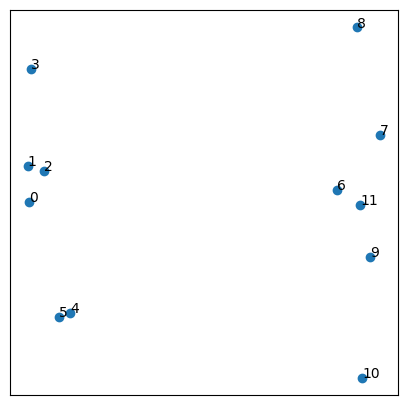

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# YOUR SOLUTION HERE

words = list(model.wv.index_to_key)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.xticks([])
plt.yticks([])
plt.show()


As you can see, the first principal component separates the two communities quite well. In other words, by simplying observing many random walk trajectories on this network, the word2vec model was able to learn that there are two clusters of nodes in the data. 

Can we use this embedding for the node classification or link prediction?

### Node classification with node embeddings

Let's try the node classification first. Instead of looking at the network neighbors, we are going to use the node embeddings. Let's look at the three nearest neighbors of each node in the embedding space. 


In [41]:
for node in G.nodes:
    print("Node id:", node)
    print("actual:", G.nodes[node]['color'])
    
    # find the 3-nearest neighbors in the embedding space and 
    # use their majority class as the prediction
    # YOUR SOLUTION HERE


Node id: 0
actual: red
predicted: red

Node id: 1
actual: red
predicted: red

Node id: 2
actual: red
predicted: red

Node id: 3
actual: red
predicted: red

Node id: 4
actual: red
predicted: red

Node id: 5
actual: red
predicted: red

Node id: 6
actual: lightblue
predicted: lightblue

Node id: 7
actual: lightblue
predicted: lightblue

Node id: 8
actual: lightblue
predicted: lightblue

Node id: 9
actual: lightblue
predicted: lightblue

Node id: 10
actual: lightblue
predicted: lightblue

Node id: 11
actual: lightblue
predicted: lightblue



Yay! A perfect prediction! 

### Link prediction with node embeddings

Let's try the link prediction next. The similarity between two nodes is simply the distance in the embedding space.

In [43]:
similarities = {}

for u, v in combinations(G.nodes, 2):
    if G.has_edge(u, v):
        continue
    # YOUR SOLUTION HERE

sorted(similarities.items(), key=lambda x: x[1], reverse=True)

[((9, 10), 0.99832845),
 ((8, 11), 0.9982137),
 ((10, 11), 0.9981303),
 ((2, 4), 0.99602705),
 ((0, 4), 0.9918693),
 ((4, 6), 0.51385474),
 ((4, 8), 0.4770486),
 ((4, 11), 0.45507237),
 ((2, 6), 0.45084545),
 ((5, 8), 0.44465238),
 ((4, 10), 0.44050527),
 ((4, 9), 0.43067354),
 ((5, 11), 0.4222979),
 ((3, 6), 0.4199267),
 ((4, 7), 0.41550887),
 ((2, 8), 0.41253433),
 ((0, 6), 0.41068062),
 ((5, 10), 0.40792263),
 ((1, 6), 0.40312147),
 ((5, 9), 0.39760047),
 ((2, 11), 0.38934413),
 ((5, 7), 0.38227364),
 ((3, 8), 0.38113827),
 ((2, 10), 0.3747149),
 ((0, 8), 0.37161374),
 ((2, 9), 0.36459893),
 ((1, 8), 0.36389732),
 ((3, 11), 0.3577143),
 ((2, 7), 0.34931344),
 ((0, 11), 0.34853363),
 ((3, 10), 0.34225166),
 ((1, 11), 0.340205),
 ((0, 10), 0.33327013),
 ((3, 9), 0.33221066),
 ((1, 10), 0.32469416),
 ((0, 9), 0.32284117),
 ((3, 7), 0.316696),
 ((1, 9), 0.3148909),
 ((0, 7), 0.3072211),
 ((1, 7), 0.29900423)]

We can again make a table. 

In [44]:
# YOUR SOLUTION HERE

similarity_df


,edge,similarity,missing,negative
0,"(9, 10)",0.998328,True,False
1,"(8, 11)",0.998214,True,False
2,"(10, 11)",0.998130,True,False
3,"(2, 4)",0.996027,True,False
4,"(0, 4)",0.991869,True,False
5,"(4, 6)",0.513855,False,False
6,"(4, 8)",0.477049,False,False
7,"(4, 11)",0.455072,False,False
8,"(2, 6)",0.450845,False,False
9,"(5, 8)",0.444652,False,False


As you can see, all the missing edges (positive set) have similarity value larger than 0.99 while all other pairs have similarity value at most about 0.5. This is pretty good!

**Q: as the final exercise, pick a small-ish real-world network, learn the node embeddings, and make both traditional network visualization (node-link diagram) and the embedding visualization. You can try PCA or UMAP.**